# Building EO training/validation/testing datasets with the Sentinelhub API

#### The following modules/Libraries will be needed

In [41]:
from sentinelhub import BBox, CRS, DataCollection, SHConfig, WmsRequest, WcsRequest, DataSource, MimeType
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import rasterio
import numpy as np
import datetime

import os 
from osgeo import gdal
import glob

import imageio

from PIL import Image
import io

from rasterio.transform import from_bounds


from matplotlib import pyplot
from rasterio.plot import show

### Prerequisites

#### Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). Inside there will already exist one configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial it is recommended that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your  configuration yourself.

After you have decided which configuration to use, you have two options. You can either put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) or you can write it down in the following cell:

Generate a configuration:
This is done using the ID.
This is so that sentinelhub knows you are authorised to use their service, and which parts of the service you want to use.

In [33]:
INSTANCE_ID = '216732ac-7e0c-46f0-a5f8-243652a55bfb'
if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

print(config)

{
  "instance_id": "216732ac-7e0c-46f0-a5f8-243652a55bfb",
  "sh_client_id": "",
  "sh_client_secret": "",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5,
  "download_timeout_seconds": 120,
  "number_of_download_processes": 1
}


Define a region and a random test date 

In [94]:
class SentinelData:
    """
    Retreiveing Sentinel data from Sentinel Hub
    initialise class with coordinates list, resolution, bounding box coordinates, years and month ranges
    make a wcs request for data between November-April
    """
    def __init__(self, coords_list, years, day_month_to, day_month_from):
        self.coords_list = coords_list
        self.resolution = '10m'
        self.area_coords = BBox(bbox=self.coords_list, crs=CRS.WGS84)
        self.year_range = years # make a set of years to iterate over 
        self.day_month_to = day_month_to
        self.day_month_from = day_month_from
        
        
        
    def retrieve_data(self):
        """ 
        Create a bounding box and assign CRS. 
        Create a wcs data request from Sentinel for Sentinel-2 data. 
        Define max clouds as 20%
        """
        for year in self.year_range:
            time_from = "{}-{}".format(year, self.day_month_from)
            print("time_from", time_from)
            time_to = "{}-{}".format(year + 1,  self.day_month_to)
            print("time_to", time_to)
            # make the request for the desired date range 
            wcs_true_color_request = WcsRequest (
                data_collection=DataCollection.SENTINEL2_L1C,
                layer='TRUE-COLOR-S2-L2A', # Layer you have configured
                bbox=self.area_coords,
                time= (time_from, time_to),
                resx=self.resolution, # Stick to 10m resolution as this the maximum possible 
                resy=self.resolution, 
                config=config,
                maxcc=0 # You can define the maximum ammount of cloud coverage you want to allow. 
            )
            print("WCS: ", wcs_true_color_request)
    
            available_dates_list = wcs_true_color_request.get_dates()
            print("avail dates list: ", available_dates_list)
            yield from available_dates_list
            
    
    def get_available_data(self):
        """
        Use get_data() function from Sentinel to retrieve available data for the dates.
        """
        available_dates_list = self.retrieve_data()
        i = 0
        for date in available_dates_list:
            i += 1
            print("date", date)
            
            wcs_true_color_request = WcsRequest(
                data_collection=DataCollection.SENTINEL2_L1C,
                layer='TRUE-COLOR-S2-L2A', # Layer you have configured
                bbox=self.area_coords, 
                time= date,
                resx=self.resolution, # Stick to 10m resolution as this the maximum possible 
                resy=self.resolution, 
                config=config,
                maxcc=0,# You can define the maximum ammount of cloud coverage you want to allow.
                data_folder='/Users/emilybirch/Documents/UCL_Dissertation' 
            )
            
            basemap = wcs_true_color_request.get_data()[0] 
            
            # call the bands_req function to wms request for bands on available dates
            call_wms = self.bands_req(basemap, date, i) # basemap,
            
            print('Returned data is of type = %s and length %d.' % (type(basemap), len(basemap)))
            print(f'Single element in the list is of type {type(basemap[-1])} and has shape {basemap[-1].shape}')
           
            
            

            
    def bands_req(self, basemap, date, i):
        """
        wms bands request for the bands making up the Sentinel pic
        """
       # for basemap in self.get_available_wms_data():
        basemap = np.array(basemap)
        wms_bands_request = WmsRequest(
            data_collection=DataCollection.SENTINEL2_L1C,
            layer='BANDS-S2-L2A', # We are using the 'BANDS-S2-L2A layer now'
            bbox= self.area_coords, # [50.19571, -124.25775, 49.98687, -123.90537], 
            width=basemap.shape[1], # 10m resolution dims are sourced from the basemap. 
            height=basemap.shape[0],
            time=(date),
            image_format=MimeType.TIFF, 
            maxcc=0,
            #resx='10m',
           # resy = '10',
            config=config,
            data_folder='/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/WMS_all_bands' 
        )        
        
        bands = wms_bands_request.get_data()[-1] # save_data=True
        bands = np.array(bands)
        bands = bands.astype('float32') 
           
        # call the split_bands function
        get_channels = self.split_bands(bands, basemap, i)

 
 
# Four coordinates representing the top-left and bottom-right of the bounding box must be separated by comma
# The bounding box in WGS84 coordinate system is (longitude and latitude coordinates of upper left and lower right corners)
# n,w, s,e

 #a list of comma-separated numbers of the form "minx,miny,maxx,maxy".       
 # s2, w2 = 49.98434, -124.25091 w,s,n,e
#n2, e2 = 50.19579, -123.90758   

# wms should be latitude, long


    
    def plot_data(self):   
        """
        Plot the RGB satellite pics to check its correct/cloud cover is acceptable
        and that the image is not cropped.
        """
        basemap = self.get_available_data()
        i = 0
        for sat_img in basemap:
            i += 1
            print("i", i)
            fig, ax = plt.subplots(1, 1, figsize=(10,10))
            plt.imshow(sat_img)
            plt.axis('off')
            plt.savefig('ala_sat_4_{}.png'.format(i),
                        bbox_inches='tight',
                        dpi=300)
            plt.show()
          

        
        
    # Download NIR (b08), DEM and Raw NDSI (no thresholding)          
    def split_bands(self, bands, basemap, i):
        """
        Split the bands req into individual bands
        Download NIR b08 as single band .tif
        Calculate NDSI and download this as .tif
        """
        #bands = self.get_available_wms_data()
            
        b01 = bands[:,:,0] # Coastal Aerosol
        b02 = bands[:,:,1] # Blue
        b03 = bands[:,:,2] # Green
        b04 = bands[:,:,3] # Red
        b05 = bands[:,:,4] # Vegetation Red Edge 
        b06 = bands[:,:,5] # Vegetation Red Edge
        b07 = bands[:,:,6] # Vegetation Red Edge
        b08 = bands[:,:,7] # NIR
        b08a = bands[:,:,8] # Vegetation Red Edge
        b09 = bands[:,:,9] # Water Vapour
        b11 = bands[:,:,10] # SWIR
        b12 = bands[:,:,11] # SWIR
        
        
        # check b08 is array
        print("TYPE OF B08:",(type(b08)))
        
        # calc NDSI from bands
        NDSI = (b03 - b11)/(b03 + b11)
        #os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/NDSI')
        #self, b03, b11, bands 
 
        # get NIR band as .tif
        raster = b08
        dim = raster.shape
        print(dim)
        height = dim[0] 
        print("height", height)
        width = dim[1] 
        print("width", width)
       # transform - NEEDS TO BE W,S,E,N. CURRENTLY THE BBOX COORDS ARE S,W,N,E. SO NEED TO SWITCH TO 116,50 NOT 50,116
        transform=from_bounds(50.19571, -124.25775, 49.98687, -123.90537, width, height)  # when its w,s,e,n its a square shape
        print("TRANSFORM:", transform)
        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/NIR')
        out_path = ('b08_can_bbox3_{}.tif'.format(i)) 
        print("OUT PATH", out_path)

        write_NIR_band = write_single_channel_gtiff(raster, width, height, transform, out_path)  # self. ?
        print(write_NIR_band)

        
# s2, w2 = 49.98434, -124.25091 w,s,n,e
#n2, e2 = 50.19579, -123.90758    







# rasterio.transform.from_bounds(west, south, east, north, width, height)
# Byte - Eight bit unsigned integer
# s2, w2 = -123.27264, 49.60259, -122.94511, 49.80043
#n2, e2 = 49.80043, -122.94511   

# bbox2 -123.27264, 49.60259, -122.94511, 49.80043





# bbox 1 -116.08768, 50.82675, -115.73474, 51.02583

def write_single_channel_gtiff(raster, width, height, transform, out_path): 
    """
    Function to write a single channel .tif file. 
    Retains the geographic info- extent, crs etc. 
    """
    assert len(raster.shape) == 2
    print(f'Writing...{out_path}')
    with rasterio.open(str(out_path),
                       mode='w',
                       crs= 'EPSG:4326',   # wgs84         
                       driver= 'GTIFF',                
                       nodata=  np.nan,
                       dtype= raster.dtype,      #  rasterio.uint8,               
                       count= 1,                 
                       height= height,         
                       width= width,     
                       # compress='lzw'
                       transform=transform # w2, s2, e2, n2, width, height. From bbox
                       ) as dst:
        dst.write(raster, 1) #.astype(np.uint8)
        


 
    
    

# make sure to only keep the pics that match the good pics used from snow labelled            
# duplicate DEM tiles for the amount of pics at each bbox
# crop tiles to extent of NIR band pics 
# resample ?
    
    
# get NDSI single band .tif  
# open NDSI, NIR and DEM and stack- put each 3 bands (NIR,DEM,NDSI) into one folder and stack


# split into tiny inputs

# model



 
  
      
         
# def stack_array(self, b08, NDSI):
#        """stack DEM, raw NDSI and NIR (b08)
            # download multi-band .tif of all three bands
#        """       

        # upload DEM files
#        dem_path = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/DEM/*tifs'
#        dem_retrieve = glob.glob(dem_path)
#        for data_path in dem_retrieve:
#        raster_dataset = gdal.Open(data_path)
        # read as array
#        dem_array = raster_dataset.ReadAsArray()

        # stack bands 
#        nir_dem_ndsi = np.stack((b08, dem, NDSI_im))
#        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/final_jpegs_NIR_NDSI_DEM')
#        imageio.imwrite(w_list[indx]+'.jpg', nir_dem_ndsi)

#TO SAVE AS A MULTIBAND IMAGE:
#gdal_merge.py -separate  -o new_rgb.tif -a_srs epsg:4326 -co PHOTOMETRIC=MINISBLACK C:\input_r.tif C:\input_g.tif C:\input_b.tif






    
# canada 0%CC. BBOX1. CANADIAN ROCKIES
#s2, w2 = 50.82675, -116.08768
#n2, e2 = 51.02583, -115.73474       


# CANADA BBOX2 0%CC. VANCOUVER. takes a long time to plot (90 plots)
#s2, w2 = 49.60259, -123.27264
#n2, e2 = 49.80043, -122.94511
    

# canada BBOX3. nr vancouver 
#s2, w2 = 49.98434, -124.25091
#n2, e2 = 50.19579, -123.90758
       
    

# MAKE OTHER BBOX JUST TO CHECK, BOX 3 
# n,w, s,e upper left lower right 
n2,w2 = 50.19571, -124.25775
s2,e2 = 49.98687, -123.90537

# OTHER WAY AROUND BOX
coords_canada = [n2, w2, s2, e2]

    
    
    
    
#bbox=self.area_coords 
# GOOD NORMAL BBOX 
coords_canada = [w2, s2, e2, n2]

canada_years = {2014, 2015, 2016, 2017, 2018, 2019, 2020}

# define the years and month ranges for data. Nov-April
canada_day_month_to = "01-01"
canada_day_month_from = "01-01"



canada_data = SentinelData(coords_canada, canada_years, canada_day_month_to, canada_day_month_from)
#plot_data_1 = canada_data.plot_data()




#plot_canada_data = canada_data.bands_req()
# plot the individual channels for Canada wms/ web req data

plot_canada_wms = canada_data.get_available_data()
#print("PLOT", plot_canada_wms)






#########################    
    
 # define the years and month ranges for data. Nov-April so there is snow cover.
# Sentinel 2 data is only available from 2015 onwards


# FORESTED:

# FRANCE BBOX 1. 0%CC
#s2, w2 = 46.00263, 6.68625
#n2, e2 = 46.21018, 7.00556


# FRANCE BBOX 2. 0%CC
#s2, w2 = 44.5032, 6.26995
#n2, e2 = 44.71395, 6.57683

# FRANCE BBOX 3. 0%CC. in Vosges mountains. 
#s2, w2 = 47.89925, 6.75874
#n2, e2 = 48.0968, 7.0709
    



# NEW ZEALAND 0% CC. BBOX1. FORESTED. gets 3 3/4 pics 
#s2, w2 = -44.64093, 168.67527
#n2,e2 = -44.42578, 168.99039


# NZ BBOX 2 FORESTED. 3 pics  
#s2,w2 = -44.46215, 169.15172
#n2,e2 = -44.26874, 169.4559


# NZ BBOX 3. 3 pics 
#s2,w2 = -45.57742, 167.32814
#n2,e2 = -45.37906, 167.63988


# NZ bbox 4. 
#s2,w2 = -44.21029, 168.7185
#n2, e2 = -43.99234, 169.00415
    

##################################    
    
# NON-FORESTED:  
# Norway. scandy mountains. works but forest?
#s2, w2 = 61.19427, 6.71053
#n2, e2 = 61.39842, 7.14765
  

# BBOX 2 
# s2, w2 = 62.11413, 11.91172
#n2, e2 = 62.31454, 12.35366


# BBOX 3. nr namsos
#s2, w2 = 64.5321, 11.68324
#n2, e2 = 64.72623, 12.17067





    
# Argentina. bbox 1. 
#s2, w2 = -36.1615, -70.60757
#n2, e2 = -36.35363, -70.87261
    

# Argentina BBOX2
#s2, w2 = -36.90052, -71.07906
#n2, e2 = -36.7103, -70.80853
    
   
 # Argentina BBOX3
#s2, w2 = -48.25276, -72.33129
#n2, e2 = -48.05762, -72.0168
       
  




 # Alaska bbox1 3 pics
#s2, w2 = 60.58666, -144.4895
#n2, e2 = 60.78174, -144.04753
    
    
    
# alaska bbox 2 2 pics
#s2, w2 = 60.54723, -145.6761
#n2, e2 = 60.74312, -145.24079
    

    
# alaska bbox 3. 3 pics
#s2, w2 = 60.86118, -146.57959
#n2, e2 = 61.05052, -146.14288


# alaska bbox 4. 3 pics 
#s2, w2 = 61.10963, -146.62525
#n2, e2 = 61.30145, -146.18168


time_from 2016-01-01
time_to 2017-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7facbfeb4f50>
avail dates list:  []
time_from 2017-01-01
time_to 2018-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7facbfd1b5d0>
avail dates list:  []
time_from 2018-01-01
time_to 2019-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7facbfd1be10>
avail dates list:  [datetime.datetime(2018, 8, 7, 19, 22, 15), datetime.datetime(2018, 8, 9, 19, 19, 41), datetime.datetime(2018, 8, 27, 19, 29, 29)]
date 2018-08-07 19:22:15


DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/ogc/wcs/216732ac-7e0c-46f0-a5f8-243652a55bfb?SERVICE=wcs&WARNINGS=False&MAXCC=0.0&BBOX=49.98687%2C-124.25775%2C50.19571%2C-123.90537&FORMAT=image%2Fpng&CRS=EPSG%3A4326&TIME=2018-08-07T19%3A22%3A15Z%2F2018-08-07T19%3A22%3A15Z&RESX=10m&RESY=10m&COVERAGE=TRUE-COLOR-S2-L2A&REQUEST=GetCoverage&VERSION=1.1.2
with HTTPError:
400 Client Error: Bad Request for url: https://services.sentinel-hub.com/ogc/wcs/216732ac-7e0c-46f0-a5f8-243652a55bfb?SERVICE=wcs&WARNINGS=False&MAXCC=0.0&BBOX=49.98687%2C-124.25775%2C50.19571%2C-123.90537&FORMAT=image%2Fpng&CRS=EPSG%3A4326&TIME=2018-08-07T19%3A22%3A15Z%2F2018-08-07T19%3A22%3A15Z&RESX=10m&RESY=10m&COVERAGE=TRUE-COLOR-S2-L2A&REQUEST=GetCoverage&VERSION=1.1.2
Server response: "Invalid request"

In [ ]:
# ON QGIS CONVERT DEM FROM INT 16 TO FLOAT 32
Algorithm Translate (convert format) starting…
Input parameters:
{'COPY_SUBDATASETS': True,
'DATA_TYPE': 6,
'EXTRA': '',
'INPUT': 'mergedNzDEM4_3381f8a4_705b_4477_982b_57a90f59bddb',
'NODATA': None,
'OPTIONS': '',
'OUTPUT': <QgsProcessingOutputLayerDefinition {'sink':/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/DEM_float32/al_DEM1mergedNzDEM4.tif, 'createOptions': {}}>,
'TARGET_CRS': None}

In [97]:
# https://stackoverflow.com/questions/10454316/how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python 


# crops AND resamples!!

from osgeo import gdal, gdalconst

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/ex')



# Source
src_filename = 'al_DEM1mergedCanDEM1.tif'
src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
src_proj = src.GetProjection()
src_geotrans = src.GetGeoTransform()

# We want a section of source that matches this:
match_filename = 'b08_can_bbox1_1.tif'
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

# Output / destination
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/resamp_crop_DEM')

dst_filename = 'Resampled_Canb1.tif'
dst = gdal.GetDriverByName('GTiff').Create(dst_filename, wide, high, 1, gdalconst.GDT_Float32)
dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

# Do the work
gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

del dst # Flush

ALL: ['Can_box1_pic1_band1.tif', 'Can_box1_pic1_band2.tif']
ALL BANDS path: ['/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/stacked/CanB1_pic1/Can_box1_pic1_band2.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/stacked/CanB1_pic1/Can_box1_pic1_band1.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2474, 'height': 2214, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00014265966046887786, 0.0, -116.08768,
       0.0, -8.991869918699284e-05, 51.02583)}
NEW TIF: canb1_pic1_stacked.tif


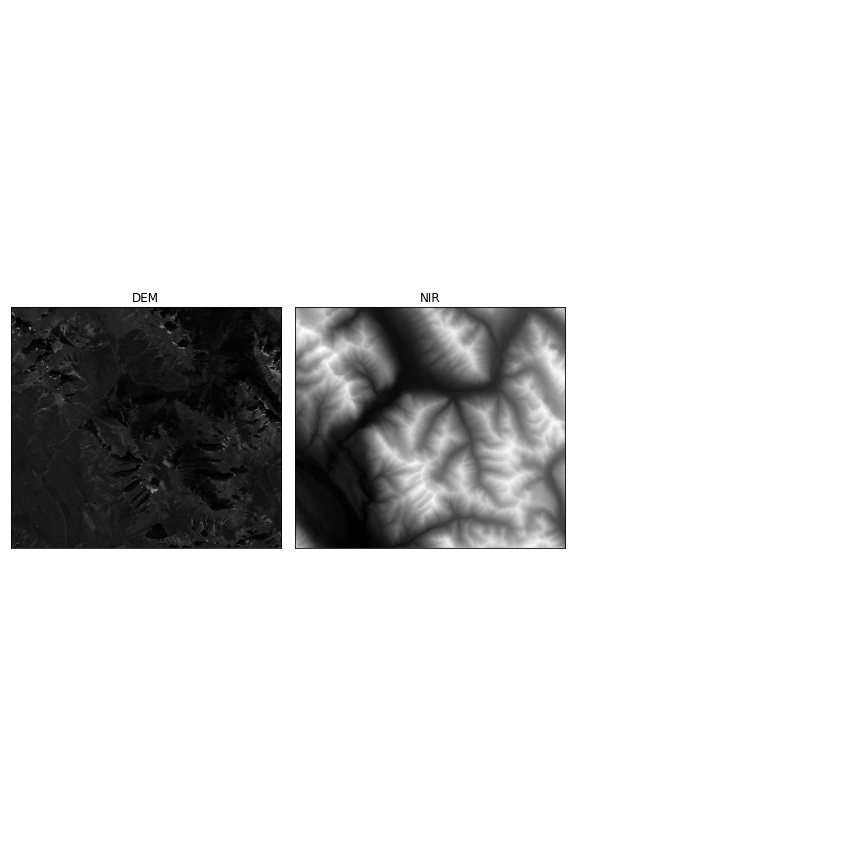

In [121]:
# stack DEM, NIR and NDSI and save as final .tif
# EarthPy has a stack() function that allows you to take a set of .tif files that are all in the same 
# spatial extent, CRS and resolution and either export them together a single stacked .tif file or work with them in Python directly as a stacked numpy array.

# use es.stack() function of earthpy library to create a raster stack of multi-band raster. It need three steps:

#Create a raster list using glob() function
#Create a path and define a name for mutli-band raster
#Apply es.stack() to creat new stacked raster with all bands save as multi tif
#Then apply rio.open to read the raster bands


# ['Data_06/RASTER/LC08_20150706_subset\\LC08_L1TP_015030_20150716_20170226_01_T1_B2.TIF',
#multi_bands=glob( "Data_06/RASTER/LC08_20150706_subset/*B[2:3:4:5]*.tif")


import glob
import earthpy.plot as ep
import earthpy.spatial as es
import rasterio as rio



def stack_array(all_bands_list, new_tif_path):  # self, b08, NDSI
    """
    stack DEM, raw NDSI and NIR (b08)
    download multi-band .tif of all three bands

    """ 
    all_bands_list = all_bands_list 
    print("ALL BANDS path:", all_bands_list)
    with rio.open(all_bands_list[0]) as src:
        meta = src.meta
        print("META:",meta)
        # Update meta to reflect the number of layers
        meta.update(count = len(all_bands_list))

        new_stacked_tif = new_tif_path
        print("NEW TIF:", new_stacked_tif)
        band_stack, bands_meta = es.stack(all_bands_list,
                                        new_stacked_tif)      

        with rio.open(new_stacked_tif) as src:
            sentinel_multi = src.read() 

        # plot all bands
        band_titles = ["DEM", "NIR"]
        ep.plot_bands(sentinel_multi,
                  title=band_titles, cbar=False)
        plt.show()





# set dir
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/stacked/CanB1_pic1')
os.getcwd()

all_bands_list = ['Can_box1_pic1_band1.tif', 'Can_box1_pic1_band2.tif']



# export as same name as snow labelled pis  
new_tif_path = "canb1_pic1_stacked.tif"

# call stack func
call_stack = stack_array(all_bands_path, new_tif_path)
            




# call stack func. # *Can_box1_pic1_band[1:2]*.tif" 
#all_bands_path = glob.glob('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/stacked/CanB1_pic1/*.tif')

#all_bands_path = glob.glob(path1)







In [112]:
import rasterio
import os 

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/stacked')

dem_raster = rasterio.open(r"Can_box1_pic1_band1.tif")
red = dem_raster.read(1, masked=True)

nir_raster = rasterio.open(r"Can_box1_pic1_band2.tif")
nir = nir_raster.read(1, masked=True)

            
            
file_list = [dem_raster, nir_raster]
with rasterio.open('out.tif', 'w', **out_meta) as dest:
    for band_nr, src in enumerate(file_list, start=1):
        dest.write(src, band_nr)

NameError: name 'out_meta' is not defined

In [ ]:
###################################################

If you just wanted to download a true colour composite, you could use WcsRequest()

If you want to access the full Sentinel-2 product (with all channels) you can use wms request. 

We can  then use band 2 and band 11 (SWIR and Blue) to create a normalised difference snow index (NDSI) and the normalised difference water index

In [65]:
# FILES HAVE MOVED, DO NOT NEED TO RUN AGAIN

# mMove and rename the single .tif tiles which do not need merging
# France bbox 2. only 1 tile, so move to final DEMs folder and rename
import shutil
shutil.move('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BOX2/tifs/ALPSMLC30_N044E006_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedFrDEM2.tif')

# Alaska: only 1 tif per. bbox2 and bbox4
import shutil
shutil.move('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX2/tifs/ALPSMLC30_N060W145_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedAlDEM2.tif')
shutil.move('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX4/tifs/ALPSMLC30_N061W146_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedAlDEM4.tif')

# Argentina
import shutil
shutil.move("/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Argentina/BOX1/tifs/ALPSMLC30_S036W070_DSM.tif", '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedArgDEM1.tif')
shutil.move("/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Argentina/BOX2/tifs/ALPSMLC30_S036W071_DSM.tif", '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedArgDEM2.tif') 
shutil.move("/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Argentina/BOX3/tifs/ALPSMLC30_S048W072_DSM.tif", '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedArgDEM3.tif') 
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BOX2/tifs/ALPSMLC30_N044E006_DSM.tif'

In [69]:
# merge DEM tiles for each bbox
import os 
from osgeo import gdal
import glob
import subprocess
import gdal
from gdalconst import GA_ReadOnly


# set dir
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/DEM_merged')
os.getcwd()

# CANADA. make a list of DEM files to merge. get all with .tif extension
can_bbox1_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX1/tifs/*.tif"
can_bbox2_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/*.tif"
can_bbox3_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/*.tif"
# retrieve files with this path name and extension
CanDEMList_1 = glob.glob(can_bbox1_path)
CanDEMList_2 = glob.glob(can_bbox2_path)
CanDEMList_3 = glob.glob(can_bbox3_path)
print(CanDEMList_3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedCanDEM1.tif"
subprocess.call(cmd.split()+CanDEMList_1)
# Canada bbox2 merge
cmd = "gdal_merge.py -o mergedCanDEM2.tif"
subprocess.call(cmd.split()+CanDEMList_2)
# Canada bbox3 merge
cmd = "gdal_merge.py -o mergedCanDEM3.tif"
subprocess.call(cmd.split()+CanDEMList_3)


# France. Set path to DEM tif files
fr_bbox1 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BBOX1/tifs/*.tif"
fr_bbox3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BOX3/tifs/*.tif"
#retrieve files with this path name and extension
fr_list1 = glob.glob(fr_bbox1)
fr_list3 = glob.glob(fr_bbox3)

# merge the DEM tiles. bbox1
cmd = "gdal_merge.py -o mergedFrDEM1.tif"
subprocess.call(cmd.split()+fr_list1)
# Fr bbox3 merge
cmd = "gdal_merge.py -o mergedFrDEM3.tif"
subprocess.call(cmd.split()+fr_list3)



# Alaska. Set path to DEM tif files
alask_path1 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BBOX1/tifs/*.tif"
alask_path3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX3/tifs/*.tif"
#retrieve files with this path name and extension
al_DEM_list1 = glob.glob(alask_path1)
al_DEM_list3 = glob.glob(alask_path3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedAlDEM1.tif"
subprocess.call(cmd.split()+al_DEM_list1)
# bbox3 merge
cmd = "gdal_merge.py -o mergedAlDEM3.tif"
subprocess.call(cmd.split()+al_DEM_list3)


# NZ. 4 bbox
nz_path3 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/NZ/BBOX3/tifs/*.tif'
nz_path4 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/NZ/BBOX4/tifs/*.tif'

nz_DEM_list3 = glob.glob(nz_path3)
nz_DEM_list4 = glob.glob(nz_path4)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedNzDEM3.tif"
subprocess.call(cmd.split()+nz_DEM_list3)
# bbox3 merge
cmd = "gdal_merge.py -o mergedNzDEM4.tif"
subprocess.call(cmd.split()+nz_DEM_list4)


# Norway
nor_path1 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Norway/bbox1/tifs/*.tif'
nor_path2 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Norway/bbox2/tifs/*.tif'
nor_path3 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Norway/bbox3/tifs/*.tif'

NorDEMList_1 = glob.glob(nor_path1)
NorDEMList_2 = glob.glob(nor_path2)
NorDEMList_3 = glob.glob(nor_path3)
print(CanDEMList_3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedNorDEM1.tif"
subprocess.call(cmd.split()+NorDEMList_1)
# Canada bbox2 merge
cmd = "gdal_merge.py -o mergedNorDEM2.tif"
subprocess.call(cmd.split()+NorDEMList_2)
# Canada bbox3 merge
cmd = "gdal_merge.py -o mergedNorDEM3.tif"
subprocess.call(cmd.split()+NorDEMList_3)




['/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N050W122_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N049W123_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N050W123_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N049W122_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N049W124_DSM.tif']
['/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N050W122_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N049W123_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N050W123_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_

0

In [ ]:
# clip to extent of another raster file
data = gdal.Open('can_sat_1_1.png', GA_ReadOnly)
print(data)
geoTransform = data.GetGeoTransform()
print("GEO", geoTransform)
minx = geoTransform[0]
print("MIN", minx)
maxy = geoTransform[3]
print("MAX", maxy)
maxx = minx + geoTransform[1] * data.RasterXSize
miny = maxy + geoTransform[5] * data.RasterYSize
call('gdal_translate -projwin ' + ' '.join([str(x) for x in [minx, maxy, maxx, miny]]) + ' -of GTiff mergedCanDEM1.tif cropCanDEM1.tif', shell=True)


In [ ]:
# clip to extent of sample pic
import numpy as np
import rasterio
from rasterio import features
from rasterio.mask import mask


# ****** make this path have both dem and NIR pics in
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/DEM_pics')
os.getcwd()

# the first one is your raster on the right. use the single band NIR .tif to crop to
# and the second one your red raster
with rasterio.open('b08_can_bbox1_1') as src, \
        rasterio.open('mergedCanDEM1.tif') as src_to_crop:
    src_affine = src.meta.get("transform") # this is s,w,n,e, height, width, pixel size etc.

    # Read the first band of the "mask" raster
    band = src.read(1)
    # Use the same value on each pixel with data
    # in order to speedup the vectorization
    band[np.where(band!=src.nodata)] = 1

    geoms = []
    for geometry, raster_value in features.shapes(band, transform=src_affine):
        # get the shape of the part of the raster
        # not containing "nodata"
        if raster_value == 1:
            geoms.append(geometry)

    # crop the second raster using the
    # previously computed shapes
    out_img, out_transform = mask(
        dataset=src_to_crop,
        shapes=geoms,
        crop=True,
    )

    # save the result
    # (don't forget to set the appropriate metadata)
    with rasterio.open(
        'result.tif',
        'w',
        driver='GTiff',
        height=out_img.shape[1],
        width=out_img.shape[2],
        count=src.count,
        dtype=out_img.dtype,
        transform=out_transform,
    ) as dst:
        dst.write(out_img)


In [ ]:
# Process DEM geomorphology pics 
# merge DEM tiles, reproject to projected crs with m units, resample to 10x10m pixel size, crop to bbox
import os 
from osgeo import gdal
import glob
import subprocess
from gdal import gdalconst



# set directory to location of all final DEM pics 
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics')
os.getcwd()

# can_list = [can_bbox1_path, can_bbox2_path, can_bbox3_path]
# i = 0
#for f in can_list:
    # i += 1
    # glob.glob(f)
    # cmd = "gdal_merge.py -o 'mergedCanDEM1_{}.tif'.format(i)"
    # subprocess.call(cmd.split()+f)

# CANADA. make a list of DEM files to merge. get all with .tif extension
can_bbox1_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX1/tifs/*.tif"
can_bbox2_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/*.tif"
can_bbox3_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/*.tif"
# retrieve files with this path name and extension
CanDEMList_1 = glob.glob(can_bbox1_path)
CanDEMList_2 = glob.glob(can_bbox2_path)
CanDEMList_3 = glob.glob(can_bbox3_path)
print(CanDEMList_3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedCanDEM1.tif"
subprocess.call(cmd.split()+CanDEMList_1)
# Canada bbox2 merge
cmd = "gdal_merge.py -o mergedCanDEM2.tif"
subprocess.call(cmd.split()+CanDEMList_2)
# Canada bbox3 merge
cmd = "gdal_merge.py -o mergedCanDEM3.tif"
subprocess.call(cmd.split()+CanDEMList_3)



# France. Set path to DEM tif files
fr_bbox1 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BBOX1/tifs/*.tif"
fr_bbox3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BOX3/tifs/*.tif"
#retrieve files with this path name and extension
fr_list1 = glob.glob(fr_bbox1)
fr_list3 = glob.glob(fr_bbox3)

# merge the DEM tiles. bbox1
cmd = "gdal_merge.py -o mergedFrDEM1.tif"
subprocess.call(cmd.split()+fr_list1)
# Fr bbox3 merge
cmd = "gdal_merge.py -o mergedFrDEM3.tif"
subprocess.call(cmd.split()+fr_list3)



# Alaska. Set path to DEM tif files
alask_path1 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BBOX1/tifs/*.tif"
alask_path3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX3/tifs/*.tif"
#retrieve files with this path name and extension
al_DEM_list1 = glob.glob(alask_path1)
al_DEM_list3 = glob.glob(alask_path3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedAlDEM1.tif"
subprocess.call(cmd.split()+al_DEM_list1)
# bbox3 merge
cmd = "gdal_merge.py -o mergedAlDEM3.tif"
subprocess.call(cmd.split()+al_DEM_list3)



# reproject coordinate system into UTM to use metres as units 
def reproj(out_file, in_file, dstSRS):
    gdal.Warp(out_file, in_file, dstSRS = crs)

# zip over lists?
# reproj for Canada: into EPSG:3978
canada_reproj_list = ['mergedCanDEM1.tif', 'mergedCanDEM2.tif', 'mergedCanDEM3.tif']
i = 0
# for in_file in zip_longest(canada_reproj_list, fr_reproj_list,al_reproj_list,... )
for in_file in canada_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojCanDEM_{}.tif'.format(i)
    crs = 'EPSG:3978'
    call = reproj(out_file, in_file, crs)
    print(call)
    
    
# France: into EPSG:23030 ED50 / UTM zone 30N
fr_reproj_list =  ['mergedFrDEM1.tif', 'mergedFrDEM2.tif', 'mergedFrDEM3.tif']
i = 0
for in_file in fr_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojFrDEM_{}.tif'.format(i)
    crs = 'EPSG:23030'
    call = reproj(out_file, in_file, crs)
    print(call)
 
 
# reproj for Alaska: into EPSG:3338
al_reproj_list = ['mergedAlDEM1.tif', 'mergedAlDEM2.tif', 'mergedAlDEM3.tif', 'mergedAlDEM4.tif']
i = 0
for in_file in al_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojAlDEM_{}.tif'.format(i)
    crs = 'EPSG:3338'
    call = reproj(out_file, in_file, crs)
    print(call)
    
# reproj for Argentina: into EPSG:5343
Arg_reproj_list = ['mergedArgDEM1.tif', 'mergedArgDEM2.tif', 'mergedArgDEM3.tif']
i = 0

for in_file in Arg_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojArgDEM_{}.tif'.format(i)
    crs = 'EPSG:5343'
    call = reproj(out_file, in_file, crs)
    print(call)
    
    
    

# Resample to 10x10m pixel size to match Sentinel images
def resample(out_file, in_file):
    gdal.Warp(out_file, in_file, xRes = 10, yRes = 10, resampleAlg = "bilinear")
    print("HI")
        

# list the files to resample and process then in a loop 
resamp_files_list = ['reprojCanDEM_1.tif', 'reprojCanDEM_2.tif', 'reprojCanDEM_3.tif']    
i = 0
for in_file in resamp_files_list:
    i += 1
    print("i", i)
    out_file = "resamp_Can_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)
            

# France: resample
resamp_list = ['reprojFrDEM_1.tif', 'reprojFrDEM_2.tif', 'reprojFrDEM_3.tif']    
i = 0
for in_file in resamp_list:
    i += 1
    print("i", i)
    out_file = "resamp_Fr_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)

    
# Alaska resample. 
# list of files to resample
resamp_list = ['reprojAlDEM_1.tif', 'reprojalDEM_2.tif', 'reprojAlDEM_3.tif', 'reprojAlDEM_4.tif']    
i = 0
for in_file in resamp_list:
    i += 1
    print("i", i)
    out_file = "resamp_Al_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)



# list the files to resample and process then in a loop 
resamp_files_list = ['reprojArgDEM_1.tif', 'reprojArgDEM_2.tif', 'reprojArgDEM_3.tif']    
i = 0
for in_file in resamp_files_list:
    i += 1
    print("i", i)
    out_file = "resamp_Arg_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)
    
    
    
    
    
# Crop .tif to boudning box coords
def crop(out_file, source_file, ulx, uly, lrx, lry):
    gdal.Translate(out_file, source_file,
                  projWin = [ulx, uly, lrx, lry])
  

 
# Canada: crop .tif to boudning box coords
can1crop = crop('cropCanDEM_1.tif','resamp_Can_DEM_1.tif', -1442222.5901271082, 465767.00799028383, -1425280.668026976, 437053.54995778797) 
can2crop = crop('cropCanDEM_2.tif','resamp_Can_DEM_2.tif', -1963467.662479708, 532524.2456295489, -1950948.5651828928, 502730.9493941085)  
can3crop = crop('cropCanDEM_3.tif','resamp_Can_DEM_3.tif',-2007237.3331321548, 602651.3553773408, -1994916.2627411576, 570806.9080293514) 
       
# France: crop .tif to boudning box coords
Fr1crop = crop('cropFrDEM_1.tif','resamp_Can_DEM_1.tif',1246969.3962645088, 5163267.284300569,1274934.6912586447, 5143545.166937985) 
Fr2crop = crop('cropFrDEM_2.tif','resamp_Can_DEM_2.tif',1234624.7084396454, 4993062.539814649, 1261497.750934254, 4974014.1117675835)  
Fr3crop = crop('cropFrDEM_3.tif','resamp_Can_DEM_3.tif', 1225777.8855382334, 5373591.730970369,1252683.6911129407, 5355278.076760378) 

# Alaska: Crop .tif to boudning box coords
Al1crop = crop('cropAlDEM_1.tif','resamp_Al_DEM_1.tif', 514481.90383768355, 1236449.1310469457, 541830.6619147946, 1218503.1192803124) 
Al2crop = crop('cropAlDEM_2.tif','resamp_Al_DEM_2.tif', 450815.2605629388, 1223929.9128310417, 477228.41344957944, 1204727.699233261)  
Al3crop = crop('cropAlDEM_3.tif','resamp_Al_DEM_3.tif', 397957.2487422569, 1251934.8385985517,425182.4670500502, 1234086.2585198171) 
Al4crop = crop('cropAlDEM_4.tif','resamp_Al_DEM_4.tif',393282.9896072386, 1280321.0557472059,419319.2191957479, 1261199.193909528) 
  

# close datasets to read properly to disk
#ds = dsReproj = dsResamp = dsClip = None


In [ ]:
# plot to check DEM is reprojected, resampled and cropped to bbox
final_DEM = gdal.Open("cropDEM_2.tif")
array = final_DEM.ReadAsArray()
plt.imshow(array)
plt.colorbar()

In [ ]:
# Argentina
import os 
from osgeo import gdal
import glob
import subprocess
from gdal import gdalconst


# set directory to location of all final DEM pics 
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics')
os.getcwd()

def crop(out_file, source_file, ulx, uly, lrx, lry):
    gdal.Translate(out_file, source_file,
                  projWin = [ulx, uly, lrx, lry])
    
  


 
# FIX THESE- CANT CROP BC NOT IN SAME AREA?
# Argentina: crop .tif to boudning box coords
Ar1crop = crop('cropArgDEM_1.tif','resamp_Arg_DEM_1.tif',5998451.786827491, 1601005.619190992,5976249.0203732345, 1625961.998551086) 
Ar2crop = crop('cropArgDEM_2.tif','resamp_Arg_DEM_2.tif',5937593.134678965, 1582258.6827567841,5916218.082539896, 1605918.8959056677)
Ar3crop = crop('cropArgDEM_3.tif','resamp_Arg_DEM_3.tif', 4676913.660264564, 1475051.4449760758, 4656287.012900037, 1499619.73136248) 


In [ ]:
# Norway
Nor1crop = crop('cropNorDEM_1.tif','resamp_Nor_DEM_1.tif',1611541.2847414473, -1150463.0893291135,1581199.9787365836, -1136330.787145058)
Nor2crop = crop('cropNorDEM_2.tif','resamp_Nor_DEM_2.tif',1619389.5743942696, -854804.3331045215,1591676.3046402216, -836971.2418011383)
Nor3crop = crop('cropNorDEM_3.tif','resamp_Nor_DEM_3.tif', 1882899.119273985, -786917.6157957469,1855046.293116921, -769771.7641124884) 




In [ ]:
# use more than one channel as input into my model. use geomorphology too.

# taking the TIFF data and encoding it to a TFRecords format for some machine learning in Tensorflow.  
# take the TIFF data, convert it to 8bit format, encode it as a string and write it to TFRecords.  


# A guide for Spectral indicies:
# https://www.geo.university/pages/blog?p=spectral-indices-with-multispectral-satellite-data


I chose a region where both water and snow are present. 
This shows that when trying to isolate snow, we also isolate water. 

But when isolating water, we, the snow is mostly left out.
This means that we can use both indicies to generate some training data

In [ ]:
def to_mask(input_image, threshold):
    input_image[input_image <= threshold] = np.nan
    input_image[input_image > threshold] = 1
    return input_image
    
NDVI_mask = to_mask(NDVI, 0.2)
NDSI_mask = to_mask(NDSI, 0.)
fig, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].set_title('NDVI Vegetation mask')
ax[0].imshow(basemap)
ax[0].imshow(NDVI_mask, cmap='cubehelix')
ax[1].set_title('NDSI Snow mask')
ax[1].imshow(basemap)
ax[1].imshow(NDSI_mask, cmap='cubehelix')

NDVI_binary_mask = np.nan_to_num(NDVI_mask)
NDSI_binary_mask = np.nan_to_num(NDSI_mask)
both = NDVI_binary_mask + NDSI_binary_mask

ax[2].set_title('NDSI mask + NDVI mask')
ax[2].imshow(both, cmap='cubehelix')

ax[3].set_title('Snow mask - Vegetation removed')
snow_only = both.copy()
snow_only[snow_only == 2] = 0
ax[3].imshow(snow_only, cmap='cubehelix')

CNN's usually don't accept big inputs, so the image needs to be cropped into smaller samples.

The bigger and more complex the CNN, the more processing power will be required, therefore the smaller the input samples will need to be. 

Rather than crushing the original sample, a good idea is to splice it. 
This way we get a lot more data, and the 10m resolution is maintained. 

In [ ]:
import math

# Split the Images
def split_image(dim_pix, im):
    # Find the number of sub-Images that fit in rows
    rows = []
    tiles = []
    for i in range((math.floor(im.shape[0] / dim_pix))):
        rows.append(i)
    # Find the number of sub-Images that fit in rows
    columns = []
    for i in range((math.floor(im.shape[1] / dim_pix))):
        columns.append(i)

    # Numerically identify the sub-Images
    a = 0
    for i in rows:
        for j in columns:
            # Check for 244 x 244 (Mask) or 244 x 244 x 3 (TC Images)
            if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[0]) == dim_pix:
                if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[1]) == dim_pix:

                    tile = im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                            0 + dim_pix * i: dim_pix + (dim_pix * i)]

                    # Stop white tiles for positive results
                    count = np.count_nonzero(tile == 1) == (dim_pix * dim_pix)
                    if count:
                        all_black = np.tile(1, (dim_pix, dim_pix))
                        tiles.append(tile)
                    else:
                        tiles.append(tile)
                    a += 1
                else:
                    print("Out of shape")
    return tiles

input_tensor_dimensions = 50
                    
basemap_tiles = split_image(dim_pix=input_tensor_dimensions, im=basemap)
label_tiles = split_image(dim_pix=input_tensor_dimensions, im=snow_only)

fig, ax = plt.subplots(len(label_tiles), 2, figsize=(2 ,len(label_tiles)))
for index in range(len(label_tiles)):
    ax[index, 0].axis('off')
    ax[index, 1].axis('off')
    ax[index, 0].imshow(basemap_tiles[index])
    ax[index, 1].imshow(label_tiles[index], cmap='Blues')

In [ ]:
# EXTRA!!!!

# EXTRA. func to convert bbox coords from geographic into projected system 
import os
import pyproj
from pyproj import Proj, transform

os.environ['PROJ_NETWORK'] = 'OFF'


def coord_conv(x1, y1, in_proj, out_proj):
    proj = pyproj.Transformer.from_crs(in_proj, out_proj)
    x2, y2 = proj.transform(x1, y1)
    print((x1, y1))
    print((x2, y2))
    return x2,y2


 
# 1. Canada:   #"epsg:4326", "epsg:3978"
#can_DEM_bbox1_ulc = coord_conv(51.02521, -116.09311, 4326, 3978)
#can_DEM_bbox1_lrc = coord_conv(50.82872, -115.73064, 4326, 3978)
# box2
#can_DEM_bbox2_ulc = coord_conv(49.7991, -123.27756,4326, 3978)
#can_DEM_bbox2_lrc = coord_conv(49.60459, -122.94316,4326, 3978)
# box3
#can_bbox3_ulc = coord_conv(50.19571, -124.25775,4326, 3978)
#can_bbox3_lrc = coord_conv(49.98687, -123.90537,4326, 3978)



# 2. France 
# bbox 1 
#Fr_bbox1_ulc = coord_conv(46.20907, 6.68394, 4326, 23030)
#Fr_bbox1_lrc = coord_conv(46.00317, 7.009, 4326, 23030)
# box2
#Fr_bbox1_ulc = coord_conv(44.71102, 6.27264,4326, 23030)
#Fr_bbox1_lrc = coord_conv(44.51403, 6.57913,4326, 23030)
# box3
#Fr_bbox1_ulc = coord_conv(48.09807, 6.75178,4326, 23030)
#Fr_bbox1_lrc = coord_conv(47.90479, 7.07567, 4326, 23030)


# Alaska
#Al_bbox1_uly = coord_conv(60.78013, -144.48842,4326, 3338)
#Al_bbox1_lrc = coord_conv(60.58568, -144.03959, 4326, 3338)

#Al_bbox2_uly = coord_conv(60.74539, -145.68114, 4326, 3338)
#Al_bbox2_lrc = coord_conv(60.54485, -145.24568, 4326, 3338)

#Al_bbox3_uly = coord_conv(61.04986, -146.59057, 4326, 3338)
#Al_bbox3_lrc = coord_conv(60.86339, -146.12749, 4326, 3338)

#Al_bbox4_uly = coord_conv(61.30673, -146.61838, 4326, 3338) 
#Al_bbox4_lrc = coord_conv(61.11029, -146.17618, 4326, 3338)


# Argentina
#Ar_bbox1_uly = coord_conv(-36.1567, -70.87755,4326, 5343)
#Ar_bbox1_lrc = coord_conv(-36.35381, -70.59671, 4326, 5343)

#Ar_bbox2_uly = coord_conv(-36.70684, -71.0794, 4326, 5343)
#Ar_bbox2_lrc = coord_conv(-36.89707, -70.81168, 4326, 5343)

#Ar_bbox3_uly = coord_conv(-48.05909, -72.3347, 4326, 5343)
#Ar_bbox3_lrc = coord_conv(-48.24508, -72.00512, 4326, 5343)


# Norway. ETRS89 / UTM is the projected CRS for Norway
Nor_bbox1_uly = coord_conv(61.39974, 6.71094,4326, 5130)
Ar_bbox1_lrc = coord_conv(61.19466, 7.15113, 4326, 5130)

Nor_bbox2_uly = coord_conv(62.31192, 11.90014, 4326, 5130)
Ar_bbox2_lrc = coord_conv(62.12052, 12.37392, 4326, 5130)

Nor_bbox3_uly = coord_conv(64.72578, 11.67157, 4326, 5130)
Nor_bbox3_lrc = coord_conv(64.53323, 12.179, 4326, 5130)




#####################
#can_list = []
# [51.02521, -116.09311,(49.7991, -123.27756), (50.19571, -124.25775)]
#x = [51.02521.....
# y = ...
#x.append
#y.append
#for coord in can_list:
#    in_proj = 4326
#    out_proj = 3978
#    x1, y1 = ulc.split(',')
#    coord_conv(x1,y1,in_proj,out_proj)


#NZ
#-44.42977, 168.66256
#-44.63339, 168.99731

#-44.26552, 169.14185
#-44.45747, 169.46413

#-45.37762, 167.32743
#-45.58001, 167.63521

#-44.00659, 168.70122
#-44.19769, 169.022

#EPSG:27200
    
    
    

# Norway
#61.39974, 6.71094
#61.19466, 7.15113

#62.31192, 11.90014
#62.12052, 12.37392

#64.72578, 11.67157
#64.53323, 12.179

#EPSG:5776

In [ ]:
# reading/ writing rasters EXTRA CODE
def access_raster(path, aoi=None):
    """
    This func says if the raster is the bbox shape, then just get info,
    if its not the bbox shape (aoi coords), then make a shape to cut the new tif to
    """ 
    # aoi is canada_coords
    if aoi == None:
        with rasterio.open(path) as src:
            array = src.read()
            meta = src.meta
            transform = src.meta['transform']
            extent = src.bounds
            extent_dims = {'north': extent.top, 'south': extent.bottom, 'west': extent.left, 'east': extent.right}
            polygon_extent = polygon_generator(extent_dims)

 

        return {'array': array, 'meta': meta, 'transform': transform, 'extent': extent, 'polygom':polygon_extent}

 

    else:
        with fiona.open(aoi, "r") as shapefile:
            shapes = [feature["geometry"] for feature in shapefile]

 

        with rasterio.open(path) as src:
            array, transform = rasterio.mask.mask(src, shapes, crop=True)
            meta = src.meta
            extent = src.bounds
        return {'array': array, 'meta': meta, 'transform': transform, 'extent': extent}


    
def write_single_channel_gtiff(raster, transform, meta,  out_path):
    assert len(raster.shape) == 2
    print(f'Writing...{out_path}')
    with rasterio.open(str(out_path),
                       mode='w',
                       crs=meta['crs'],
                       driver=meta['driver'],
                       nodata=np.nan,
                       dtype=meta['dtype'],
                       count=meta['count'],
                       height=raster.shape[0],
                       width=raster.shape[1],
                       transform=transform
                       ) as dst:
        dst.write(raster, 1)
        
    
    
##############
From raster.crs import CRS

def get_raster_info(raster):
    data_type = raster.dtype
    print(data_type)
    dim = raster.shape
    print(dim)
    height = dim[1]
    width = dim[2]

    

transform=from_bounds(w2, s2, e2, n2, width, height)


#With raster.open(“./output.tif”, “w”, 
#    driver = driver,
#    height = height,
#    width = width,
#    count = count,
#    typed = dtype,
#    crs = crs,
#    transform = transform) as dst:
#dst.write(array)

###################


transform=from_bounds(w2, s2, e2, n2, width, height)
# rasterio.transform.from_bounds(west, south, east, north, width, height)

crs_img='EPSG:4326'

from rasterio.transform import from_bounds
with rasterio.open('test1.tif', 
                    'w',
                    driver='GTiff',
                    height=NDSI.shape[0],
                    width=NDSI.shape[1],
                    count=1,
                    dtype=NDSI.dtype,
                    crs=crs_img,
                    nodata=None, # change if data has nodata value
                    transform=transform) as dst:
        dst.write(ndvi, 1)
 


 
################
# write an array into a new single band .tiff
with rasterio.Env():
    # write an array as a raster band to a new 8bit file
    profile.update(
        dtype=rasterio.unit8,
        count=1,
        compress='lzw')
    
    with rasterio.open('example.tif', 'w', **profile) as dst:
        dst.write(array.astype(rasterio.unit8), 1) 
        
        
        
############        
import gdal
# read raster
gdal.AllRegister()
inRaster ='input raster'
inDS=gdal.Open(inRaster,1)
geoTransform = inDs.GetGeoTransform()
band=inDS.GetRasterBand(1)
datatype=band.DataType
proj=inDS.GetProjection()
        
# write raster
driver = inDS.GetDriver()
outDS= driver.Create(outRaster,No_cols,No_rows,1,datatype)
geoTransform = inDS.GetGeoTransform()
outDS.SetProjection(proj)
outBand=outDS.GetRasterBand(1)
# data is the output array written in.tiff file
outBand.WriteArray(data,0,0)
outDS=None

            
############
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# import 
ds = gdal.Open("dem.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

band = ds.GetRasterBand(1)
array = band.ReadAsArray()

plt.figure()
plt.imshow(array)

# manipulate
#binmask = np.where((array \&gt = np.mean(array)),1,0)
#plt.figure()
#plt.imshow(binmask)

# export
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("output.tif", xsize = array.shape[1],
                      ysize = array.shape[0], bands = 1, 
                      eType = gdal.GDT_Int16) # GDT_Byte 
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(array)
outband.SetNoDataValue(np.nan)
outband.FlushCache()

# close your datasets and bands!!!
outband = None
outds = None

In [ ]:
# EXTRA FOR resample raster
# upsampling refers to cases where we are converting to higher resolution/smaller cells.
# nearest neighbour method of resampling is not suitable for continuous data i.e. DEM
# use bilinear instead 

import rasterio
from rasterio.enums import Resampling

upscale_factor = 3

with rasterio.open("mergedCanDEM1.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )


In [ ]:
# EXTRA FOR PLOTTING/ SAVING BAND AS PNG


      # extra to plot the NDSI and NIR  
      #  for channels in bands:
       #     i += 1
       #     print("i", i)
          #  fig, ax = plt.subplots(2, 6, figsize=(15,10))
          #  ax[0, 2].imshow(b03, cmap='cubehelix')
          #  ax[0, 2].set_title('Green')
          #  ax[1, 0].imshow(b08, cmap='cubehelix')
          #  ax[1, 0].set_title('Vegetation Red Edge ')
          #  ax[1, 3].imshow(b11, cmap='cubehelix')
          #  ax[1, 3].set_title('SWIR')
          #  ax[1, 3].axis('off')

        #    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/WMS_all_bands')
        #    plt.savefig("can_bands_{}.tif".format(i),
        #                bbox_inches='tight',
        #                    dpi=600)

         #   plt.show()
       

      
 #   def calc_ndsi(self, b03, b11, bands):
        """
        Plot ndsi using certain bands
        EXPORT AS PNG
        """
       # NDVI = (b04 – b03) / (b04 + b03)       
        # plot true colour image:
       # ax[0].imshow(basemap)
       # ax[0].set_title('True Colour Composite')  
        # Normalised difference snow index 
    
  #      os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/NDSI')
  #      i = 0
  #      NDSI = (b03 - b11)/(b03 + b11)
  #      for ndsi_im in bands:
  #          i += 1
        #   ndsi_im = Image.fromarray(NDSI) #.save('can_NDSI_{}.tif'.format(i)) # NDSI.astype(np.uint8)
 #           fig, ax = plt.subplots(1, 1, figsize=(15,10))
  #          plt.imshow(NDSI, cmap='Blues')
   #         plt.axis('off')            
   ##         plt.savefig('can_NDSI_{}.tif'.format(i),
   #                     bbox_inches='tight', dpi=600, format="tiff")
   #         plt.show()  